# PySpark for BigMart Sales

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Analysis-BigMart').getOrCreate()
data = spark.read.csv('train.csv', header = True, inferSchema = True)
data.printSchema()

root
 |-- Item_Identifier: string (nullable = true)
 |-- Item_Weight: double (nullable = true)
 |-- Item_Fat_Content: string (nullable = true)
 |-- Item_Visibility: double (nullable = true)
 |-- Item_Type: string (nullable = true)
 |-- Item_MRP: double (nullable = true)
 |-- Outlet_Identifier: string (nullable = true)
 |-- Outlet_Establishment_Year: integer (nullable = true)
 |-- Outlet_Size: string (nullable = true)
 |-- Outlet_Location_Type: string (nullable = true)
 |-- Outlet_Type: string (nullable = true)
 |-- Item_Outlet_Sales: double (nullable = true)



In [2]:
data.show(5, truncate=False)

+---------------+-----------+----------------+---------------+---------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|Item_Type            |Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|Outlet_Type      |Item_Outlet_Sales|
+---------------+-----------+----------------+---------------+---------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+
|FDA15          |9.3        |Low Fat         |0.016047301    |Dairy                |249.8092|OUT049           |1999                     |Medium     |Tier 1              |Supermarket Type1|3735.138         |
|DRC01          |5.92       |Regular         |0.019278216    |Soft Drinks          |48.2692 |OUT018           |2009                     |Medium     |Tier 3              |Su

In [3]:
data.describe().show()

+-------+---------------+------------------+----------------+-------------------+-------------+-----------------+-----------------+-------------------------+-----------+--------------------+-----------------+------------------+
|summary|Item_Identifier|       Item_Weight|Item_Fat_Content|    Item_Visibility|    Item_Type|         Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|      Outlet_Type| Item_Outlet_Sales|
+-------+---------------+------------------+----------------+-------------------+-------------+-----------------+-----------------+-------------------------+-----------+--------------------+-----------------+------------------+
|  count|           8523|              7060|            8523|               8523|         8523|             8523|             8523|                     8523|       6113|                8523|             8523|              8523|
|   mean|           null|12.857645184136183|            null|0.06613202877895127|       

In [4]:
import pyspark.sql.functions as f

# null values in each column
data_agg = data.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data.columns])
data_agg.show()

+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|Item_Type|Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|Outlet_Type|Item_Outlet_Sales|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|              0|       1463|               0|              0|        0|       0|                0|                        0|       2410|                   0|          0|                0|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+



## Fill NA with mean and mode

In [5]:
data.agg({'Item_Weight': 'mean'}).show()

+------------------+
|  avg(Item_Weight)|
+------------------+
|12.857645184136183|
+------------------+



In [6]:
data = data.fillna( { 'Item_Weight':12.857645184136183 } )

In [7]:
data.groupBy('Outlet_Size').count().show()

+-----------+-----+
|Outlet_Size|count|
+-----------+-----+
|       High|  932|
|       null| 2410|
|     Medium| 2793|
|      Small| 2388|
+-----------+-----+



In [8]:
data = data.fillna( { 'Outlet_Size':'Medium' } )

In [9]:
import pyspark.sql.functions as f

# null values in each column
data_agg = data.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data.columns])
data_agg.show()

+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|Item_Type|Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|Outlet_Type|Item_Outlet_Sales|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|              0|          0|               0|              0|        0|       0|                0|                        0|          0|                   0|          0|                0|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+



## Label Encoding

In [10]:
from pyspark.ml.feature import StringIndexer

# create object of StringIndexer class and specify input and output column
SI_Fat = StringIndexer(inputCol='Item_Fat_Content',outputCol='Item_Fat_Content_Index')
SI_Type = StringIndexer(inputCol='Item_Type',outputCol='Item_Type_Index')
SI_Size = StringIndexer(inputCol='Outlet_Size',outputCol='Outlet_Size_Index')
SI_Location = StringIndexer(inputCol='Outlet_Location_Type',outputCol='Outlet_Location_Type_Index')
SI_Out_Type = StringIndexer(inputCol='Outlet_Type',outputCol='Outlet_Type_Index')

# transform the data
data = SI_Fat.fit(data).transform(data)
data = SI_Type.fit(data).transform(data)
data = SI_Size.fit(data).transform(data)
data = SI_Location.fit(data).transform(data)
data = SI_Out_Type.fit(data).transform(data)

# view the transformed data
data.first()

Row(Item_Identifier='FDA15', Item_Weight=9.3, Item_Fat_Content='Low Fat', Item_Visibility=0.016047301, Item_Type='Dairy', Item_MRP=249.8092, Outlet_Identifier='OUT049', Outlet_Establishment_Year=1999, Outlet_Size='Medium', Outlet_Location_Type='Tier 1', Outlet_Type='Supermarket Type1', Item_Outlet_Sales=3735.138, Item_Fat_Content_Index=0.0, Item_Type_Index=4.0, Outlet_Size_Index=0.0, Outlet_Location_Type_Index=2.0, Outlet_Type_Index=0.0)

## One Hot Encoding

In [11]:
from pyspark.ml.feature import OneHotEncoder
OHE = OneHotEncoder(inputCols=['Item_Fat_Content_Index', 'Item_Type_Index', 'Outlet_Size_Index', 'Outlet_Location_Type_Index', 'Outlet_Type_Index'],outputCols=['Item_Fat_Content_OHE', 'Item_Type_OHE', 'Outlet_Size_OHE', 'Outlet_Location_Type_OHE', 'Outlet_Type_OHE'])

# transform the data
data = OHE.fit(data).transform(data)

In [12]:
data.take(1)

[Row(Item_Identifier='FDA15', Item_Weight=9.3, Item_Fat_Content='Low Fat', Item_Visibility=0.016047301, Item_Type='Dairy', Item_MRP=249.8092, Outlet_Identifier='OUT049', Outlet_Establishment_Year=1999, Outlet_Size='Medium', Outlet_Location_Type='Tier 1', Outlet_Type='Supermarket Type1', Item_Outlet_Sales=3735.138, Item_Fat_Content_Index=0.0, Item_Type_Index=4.0, Outlet_Size_Index=0.0, Outlet_Location_Type_Index=2.0, Outlet_Type_Index=0.0, Outlet_Type_OHE=SparseVector(3, {0: 1.0}), Item_Fat_Content_OHE=SparseVector(4, {0: 1.0}), Outlet_Size_OHE=SparseVector(2, {0: 1.0}), Outlet_Location_Type_OHE=SparseVector(2, {}), Item_Type_OHE=SparseVector(15, {4: 1.0}))]

## Vectorizing into single Feature

In [13]:
from pyspark.ml.feature import VectorAssembler

inputcol = ['Item_Fat_Content_Index', 'Item_Type_Index', 'Outlet_Size_Index', 'Outlet_Location_Type_Index', 'Outlet_Type_Index','Item_Fat_Content_OHE', 'Item_Type_OHE', 'Outlet_Size_OHE', 'Outlet_Location_Type_OHE', 'Outlet_Type_OHE', 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=inputcol, outputCol='features')

# fill the null values
data = data.fillna(0)

# transform the data
final_data = assembler.transform(data)

In [14]:
final_data.take(1)

[Row(Item_Identifier='FDA15', Item_Weight=9.3, Item_Fat_Content='Low Fat', Item_Visibility=0.016047301, Item_Type='Dairy', Item_MRP=249.8092, Outlet_Identifier='OUT049', Outlet_Establishment_Year=1999, Outlet_Size='Medium', Outlet_Location_Type='Tier 1', Outlet_Type='Supermarket Type1', Item_Outlet_Sales=3735.138, Item_Fat_Content_Index=0.0, Item_Type_Index=4.0, Outlet_Size_Index=0.0, Outlet_Location_Type_Index=2.0, Outlet_Type_Index=0.0, Outlet_Type_OHE=SparseVector(3, {0: 1.0}), Item_Fat_Content_OHE=SparseVector(4, {0: 1.0}), Outlet_Size_OHE=SparseVector(2, {0: 1.0}), Outlet_Location_Type_OHE=SparseVector(2, {}), Item_Type_OHE=SparseVector(15, {4: 1.0}), features=SparseVector(35, {1: 4.0, 3: 2.0, 5: 1.0, 13: 1.0, 24: 1.0, 28: 1.0, 31: 9.3, 32: 0.016, 33: 249.8092, 34: 1999.0}))]

In [15]:
df_train = final_data.select(['features', 'Item_Outlet_Sales'])

In [16]:
df_train.take(1)

[Row(features=SparseVector(35, {1: 4.0, 3: 2.0, 5: 1.0, 13: 1.0, 24: 1.0, 28: 1.0, 31: 9.3, 32: 0.016, 33: 249.8092, 34: 1999.0}), Item_Outlet_Sales=3735.138)]

In [17]:
df_train.show(5)

+--------------------+-----------------+
|            features|Item_Outlet_Sales|
+--------------------+-----------------+
|(35,[1,3,5,13,24,...|         3735.138|
|(35,[0,1,4,6,17,2...|         443.4228|
|(35,[1,3,5,18,24,...|          2097.27|
|(35,[0,4,6,9,24,2...|           732.38|
|(35,[1,2,5,11,26,...|         994.7052|
+--------------------+-----------------+
only showing top 5 rows



## Split train and test

In [18]:
train_df, test_df = df_train.randomSplit([0.8, 0.2])

## Applying various models in Pyspark Api

In [30]:
# Linear Regression Model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=150, regParam=0.0, elasticNetParam=0.0)
lr_model = lr.fit(train_df)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)

# Predict and Evaluate
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

lr_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_r2.evaluate(lr_predictions))

RMSE: 1133.476559
R2: 0.554448
+-------------------+-----------------+--------------------+
|         prediction|Item_Outlet_Sales|            features|
+-------------------+-----------------+--------------------+
|  729.2843759230018|         331.5684|(35,[0,1,2,3,4,6,...|
|  384.5975328735367|         425.4462|(35,[0,1,2,3,4,6,...|
| 1136.7232229275978|          945.436|(35,[0,1,2,3,4,6,...|
|-153.25180773547618|         317.5866|(35,[0,1,2,3,4,6,...|
| -30.22022594201553|         113.8518|(35,[0,1,2,3,4,6,...|
+-------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1106.76
R Squared (R2) on test data = 0.593892


In [23]:
#  Lasso Regression Model
lar = LinearRegression(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=100, regParam=0.3, elasticNetParam=1)
lar_model = lar.fit(train_df)

trainingSummary = lar_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)

# Predict and Evaluate
lar_predictions = lar_model.transform(test_df)
lar_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

lar_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % lar_evaluator.evaluate(lar_predictions))

lar_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % lar_evaluator_r2.evaluate(lar_predictions))

RMSE: 1133.589738
R2: 0.554359
+-------------------+-----------------+--------------------+
|         prediction|Item_Outlet_Sales|            features|
+-------------------+-----------------+--------------------+
|  723.1792481893208|         331.5684|(35,[0,1,2,3,4,6,...|
| 378.63698723577545|         425.4462|(35,[0,1,2,3,4,6,...|
|  1130.646491530053|          945.436|(35,[0,1,2,3,4,6,...|
|-158.85101700072846|         317.5866|(35,[0,1,2,3,4,6,...|
| -35.82258349095355|         113.8518|(35,[0,1,2,3,4,6,...|
+-------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1106.86
R Squared (R2) on test data = 0.593819


In [26]:
# Decision Tree Regression Model
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxDepth=15, minInstancesPerNode=100)
dt_model = dt.fit(train_df)

# Predict and Evaluate
dt_predictions = dt_model.transform(test_df)
dt_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

df_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % df_evaluator.evaluate(dt_predictions))

df_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % df_evaluator_r2.evaluate(dt_predictions))

+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|394.03078252427184|         331.5684|(35,[0,1,2,3,4,6,...|
| 283.3360183206108|         425.4462|(35,[0,1,2,3,4,6,...|
|500.69881896551715|          945.436|(35,[0,1,2,3,4,6,...|
|223.94658571428573|         317.5866|(35,[0,1,2,3,4,6,...|
| 283.3360183206108|         113.8518|(35,[0,1,2,3,4,6,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1057.63
R Squared (R2) on test data = 0.629148


In [27]:
## GBT Regression Model
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=10)
# gbt = GBTRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', maxIter=10, maxDepth=15, minInstancesPerNode=100)
gbt_model = gbt.fit(train_df)

# Predict and Evaluate
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

gbt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")
print("Root Mean Square Error (RMSE) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

gbt_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator_r2.evaluate(gbt_predictions))

+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|477.42167799114003|         331.5684|(35,[0,1,2,3,4,6,...|
|342.25790791842667|         425.4462|(35,[0,1,2,3,4,6,...|
| 541.6654409408936|          945.436|(35,[0,1,2,3,4,6,...|
| 245.1703909636694|         317.5866|(35,[0,1,2,3,4,6,...|
|311.27774749352017|         113.8518|(35,[0,1,2,3,4,6,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1047.03
R Squared (R2) on test data = 0.636544


In [29]:
# RandomForest Regression Model
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol='Item_Outlet_Sales', minInstancesPerNode=150)

rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="rmse")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 6, 10]) \
    .addGrid(rf.numTrees, [200, 400]) \
    .build()

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=rf_evaluator, numFolds=5, parallelism=5)

cv_model = cv.fit(train_df)

rf_predictions = cv_model.transform(test_df)
rf_predictions.select("prediction","Item_Outlet_Sales","features").show(5)

print("Root Mean Square Error (RMSE) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

rf_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Item_Outlet_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator_r2.evaluate(rf_predictions))

+------------------+-----------------+--------------------+
|        prediction|Item_Outlet_Sales|            features|
+------------------+-----------------+--------------------+
|441.65932039560516|         331.5684|(35,[0,1,2,3,4,6,...|
|  325.619648765012|         425.4462|(35,[0,1,2,3,4,6,...|
|473.97048510979783|          945.436|(35,[0,1,2,3,4,6,...|
|309.47752994468544|         317.5866|(35,[0,1,2,3,4,6,...|
|319.80938730928233|         113.8518|(35,[0,1,2,3,4,6,...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Square Error (RMSE) on test data = 1047.03
R Squared (R2) on test data = 0.61196


# Results

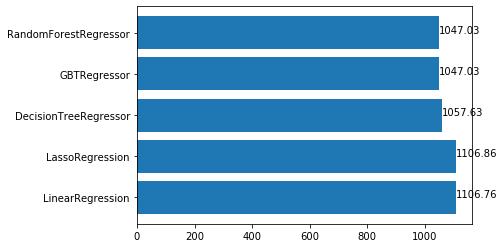

In [33]:
import numpy as np 
import matplotlib.pyplot as plt 

models = ['LinearRegression', 'LassoRegression', 'DecisionTreeRegressor', 
		'GBTRegressor', 'RandomForestRegressor'] 

data = [1106.76, 1106.86, 1057.63, 1047.03, 1047.03]
  
plt.barh(models, data) 
  
for index, value in enumerate(data): 
    plt.text(value, index, 
             str(value)) 
  
plt.show() 

### Here we can easily see that RFR and GBT outplayed all the other models as they have least RMSE scores on test_dataset.
### Improvements can be done as we can apply ANN and also can change the parameters in CrossValidations and other models' arguments as well.
### We can even apply word embeddings as in case of neuralNets as well.